In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
import ast
import glob
import pickle
import dask
import os
import itertools


#from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score


from multiprocessing import Pool, cpu_count

import dask
import dask.dataframe as dd
from dask.distributed import Client
#client = Client(n_workers=20, memory_limit="10GB", interface='lo')
from concurrent.futures import ThreadPoolExecutor

import dask_ml.cluster as dask_cluster

from pprint import pprint
import os

In [2]:
pd.set_option('display.max_columns', None)

### Define Weighing Function

In [3]:
def mu_helper(j, delta):
    assert isinstance(delta, int) and delta >= 2, "delta must be integer larger than 2"
    
    numerator = np.sum([i - (delta-1)*0.5 for i in range(j, delta)])
    denominator = np.sum([i*(i-(delta-1)*0.5) for i in range(delta)])
    
    weight = numerator/denominator
    
    return weight

def mu(delta):
    return np.asarray([mu_helper(j, delta) for j in range(1, delta)])

In [4]:
delta_weights = {}
delta_list = [2,3,4,7,14]
for delta in delta_list:
    delta_weights[delta] = mu(delta)
    print("Weights for delta={} are {}".format(delta,delta_weights[delta]))

Weights for delta=2 are [1.]
Weights for delta=3 are [0.5 0.5]
Weights for delta=4 are [0.3 0.4 0.3]
Weights for delta=7 are [0.10714286 0.17857143 0.21428571 0.21428571 0.17857143 0.10714286]
Weights for delta=14 are [0.02857143 0.05274725 0.07252747 0.08791209 0.0989011  0.10549451
 0.10769231 0.10549451 0.0989011  0.08791209 0.07252747 0.05274725
 0.02857143]


### Reimport Historical TLGRF Estimates

In [5]:
merged_TLGRF_results = dd.read_csv("../generate_benchmark_TLGRF_dataset/benchmark_TLGRF_dataset.csv", assume_missing=True).compute()
merged_TLGRF_results["date"] = pd.to_datetime(merged_TLGRF_results["date"])
merged_TLGRF_results = merged_TLGRF_results.sort_values(by=["fips","date"])

In [6]:
# check for gaps
grouped = merged_TLGRF_results.groupby('fips')

for fips, group in grouped:
    missing_days = group['days_from_start'].diff().gt(1).sum()
    if missing_days > 0:
        print(f"Gap(s) found in 'days_from_start' for fips {fips}: {missing_days} gap(s)")

In [7]:
merged_TLGRF_results.columns

Index(['fips', 'days_from_start', 'intercept_TLGRF', 'r_TLGRF', 'county',
       'state', 'date', 'rolled_cases', 'log_rolled_cases',
       'shifted_log_rolled_cases', 'TLGRF_predicted_log_rolled_cases'],
      dtype='object')

### Generate Composite `r_TLGRF(delta)` and subsequent predictions

In [8]:
cols_to_keep = ["fips", "county", "state", "date", "days_from_start", "r_TLGRF", "log_rolled_cases", "shifted_log_rolled_cases", "TLGRF_predicted_log_rolled_cases"]
kept_merged_TLGRF_results = merged_TLGRF_results[cols_to_keep]
kept_merged_TLGRF_results["date"] = pd.to_datetime(kept_merged_TLGRF_results["date"])
# Generate the past 13 days of r
for i in range(0,14):
    col_name = "r_TLGRF_{}_days_before".format(i)
    kept_merged_TLGRF_results[col_name] = kept_merged_TLGRF_results.groupby("fips")["r_TLGRF"].shift(i)
# Gnerate the composite TLGRF_r(delta) and the prediction 7 days later
for delta in delta_list:
    col_name = "r_TLGRF_delta={}".format(delta)
    kept_merged_TLGRF_results[col_name] = 0
    rs = kept_merged_TLGRF_results[["r_TLGRF_{}_days_before".format(i) for i in range(delta-1)]].values
    kept_merged_TLGRF_results[col_name] = rs @ delta_weights[delta]
    
    kept_merged_TLGRF_results["TLGRF_delta={}_predicted_log_rolled_cases".format(delta)] = kept_merged_TLGRF_results[col_name] * 7 + kept_merged_TLGRF_results["log_rolled_cases"]

#kept_merged_TLGRF_results = kept_merged_TLGRF_results.dropna(subset=["TLGRF_delta={}_predicted_log_rolled_cases".format(delta_list[-1])])
kept_merged_TLGRF_results = kept_merged_TLGRF_results[kept_merged_TLGRF_results["log_rolled_cases"] >= np.log(20 + 1.1)]
kept_merged_TLGRF_results = kept_merged_TLGRF_results[kept_merged_TLGRF_results["date"] <= "2022-12-31"]

/home/zwang937/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/zwang937/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [9]:
kept_merged_TLGRF_results.head()

,fips,county,state,date,days_from_start,r_TLGRF,log_rolled_cases,shifted_log_rolled_cases,TLGRF_predicted_log_rolled_cases,r_TLGRF_0_days_before,r_TLGRF_1_days_before,r_TLGRF_2_days_before,r_TLGRF_3_days_before,r_TLGRF_4_days_before,r_TLGRF_5_days_before,r_TLGRF_6_days_before,r_TLGRF_7_days_before,r_TLGRF_8_days_before,r_TLGRF_9_days_before,r_TLGRF_10_days_before,r_TLGRF_11_days_before,r_TLGRF_12_days_before,r_TLGRF_13_days_before,r_TLGRF_delta=2,TLGRF_delta=2_predicted_log_rolled_cases,r_TLGRF_delta=3,TLGRF_delta=3_predicted_log_rolled_cases,r_TLGRF_delta=4,TLGRF_delta=4_predicted_log_rolled_cases,r_TLGRF_delta=7,TLGRF_delta=7_predicted_log_rolled_cases,r_TLGRF_delta=14,TLGRF_delta=14_predicted_log_rolled_cases
17,1001.0,Autauga,Alabama,2020-04-16,86.0,NaN,3.062723,3.133629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,1001.0,Autauga,Alabama,2020-04-17,87.0,0.028066,3.082565,3.170286,3.279026,0.028066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028066,3.279026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,1001.0,Autauga,Alabama,2020-04-18,88.0,0.007752,3.082565,3.205646,3.136830,0.007752,0.028066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007752,3.136830,0.017909,3.207928,NaN,NaN,NaN,NaN,NaN,NaN
20,1001.0,Autauga,Alabama,2020-04-19,89.0,0.021119,3.095578,3.228543,3.243410,0.021119,0.007752,0.028066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021119,3.243410,0.014436,3.196626,0.017856,3.220572,NaN,NaN,NaN,NaN
21,1001.0,Autauga,Alabama,2020-04-20,90.0,0.022045,3.114784,3.256447,3.269100,0.022045,0.021119,0.007752,0.028066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022045,3.269100,0.021582,3.265858,0.017387,3.236491,NaN,NaN,NaN,NaN


### Evaluate Daily Mean RMSE and MAE

In [10]:
TLGRF_delta_performance = pd.DataFrame()
# Define

for delta in delta_list:
    TLGRF_delta_RMSE = kept_merged_TLGRF_results.groupby("date").apply(lambda x: np.sqrt(np.nanmean((x['shifted_log_rolled_cases'] - x['TLGRF_delta={}_predicted_log_rolled_cases'.format(delta)])**2)))
    TLGRF_delta_MAE = kept_merged_TLGRF_results.groupby("date").apply(lambda x: np.nanmean(np.abs(x['shifted_log_rolled_cases'] - x['TLGRF_delta={}_predicted_log_rolled_cases'.format(delta)])))
    
    TLGRF_delta_performance["RMSE_delta={}".format(delta)] = TLGRF_delta_RMSE
    TLGRF_delta_performance["MAE_delta={}".format(delta)] = TLGRF_delta_MAE
TLGRF_delta_performance.index = pd.to_datetime(TLGRF_delta_performance.index)

/home/zwang937/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/zwang937/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/zwang937/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/zwang937/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/zwang937/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/zwang937/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/zwang937/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/zwang937/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/zwang937/anaconda3/lib/python3.7/site-packages

In [11]:
TLGRF_delta_performance

,RMSE_delta=2,MAE_delta=2,RMSE_delta=3,MAE_delta=3,RMSE_delta=4,MAE_delta=4,RMSE_delta=7,MAE_delta=7,RMSE_delta=14,MAE_delta=14
date,,,,,,,,,,
2020-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.263357,0.199477,0.260234,0.198691,0.263199,0.198645,0.274678,0.202469,0.291061,0.234248
2022-12-28,0.181111,0.130100,0.207506,0.160594,0.222409,0.171341,0.249803,0.189417,0.271391,0.217673
2022-12-29,0.174124,0.112732,0.176774,0.125144,0.184753,0.138430,0.215541,0.163587,0.244277,0.193188


In [12]:
#for delta in delta_list[1:]:
def plot_comparison(delta1=2, delta2=3, metric="RMSE"):
    plt.clf()
    fig, (ax1) = plt.subplots(1, 1, figsize=(15,5))
    ax1.plot(TLGRF_delta_performance["{}_delta={}".format(metric, delta1)], label="TLGRF $\delta$={}".format(delta1), color="red")
    ax1.plot(TLGRF_delta_performance["{}_delta={}".format(metric, delta2)], label="TLGRF $\delta$={}".format(delta2), linestyle="dashed")
    
    full_metric = "Mean Absolute Error (MAE)"
    if metric == "RMSE":
        "Root Mean Square Error (RMSE)"

    ax1.set(title='{} in One-Week Ahead COVID Case Predictions'.format(full_metric), xlabel='Date', ylabel=metric)
    #ax1.set_xticks(TLGRF_delta_performance.index[TLGRF_delta_performance.index.is_month_start])
    #ax1.set_xticklabels(TLGRF_delta_performance.index[TLGRF_delta_performance.index.is_month_start].strftime('%Y-%m-%d'), rotation=45)
    #ax1.tick_params(axis='x', which='both', bottom=False, top=False)
    ax1.set_xlim(pd.to_datetime("2020-03-15"), pd.to_datetime("2023-01-01"))
    ylim_dict = {"RMSE": 1.0, "MAE": 0.6}
    ax1.set_ylim(0, ylim_dict[metric])
    ax1.legend()
    plt.tight_layout()
    plt.show()
    ax1.figure.savefig("TLGRF_Delta_{}_{{{}x{}}}.png".format(metric,delta1,delta2))
    



In [13]:
list(itertools.product([3,4,7,14],["RMSE","MAE"]))

[(3, 'RMSE'),
 (3, 'MAE'),
 (4, 'RMSE'),
 (4, 'MAE'),
 (7, 'RMSE'),
 (7, 'MAE'),
 (14, 'RMSE'),
 (14, 'MAE')]

<Figure size 640x480 with 0 Axes>

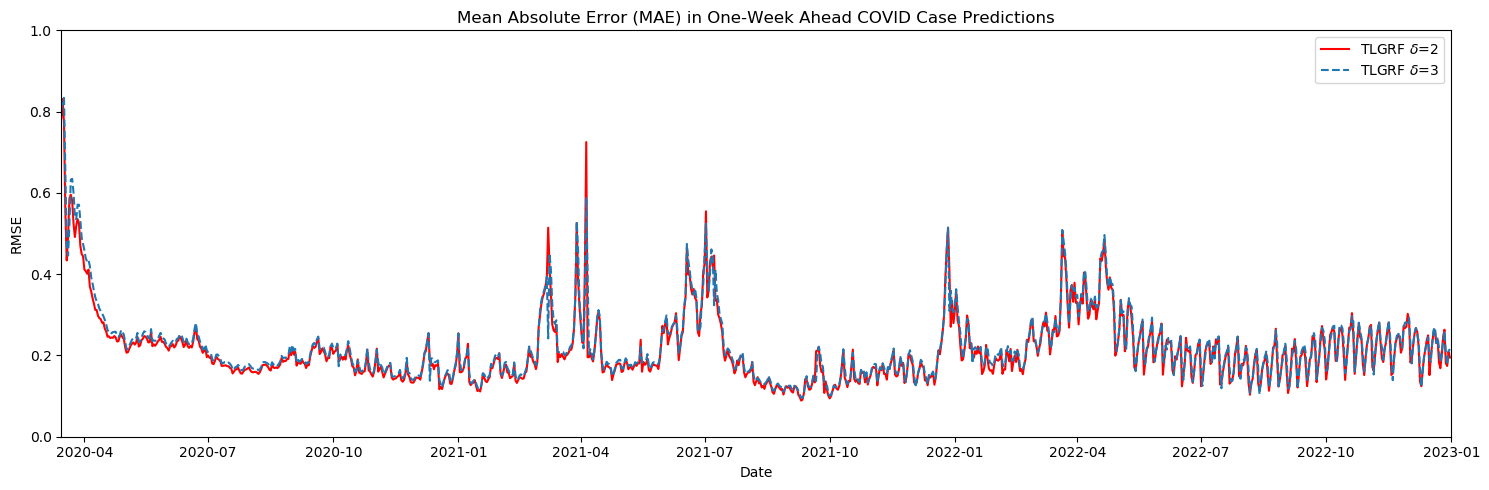

<Figure size 640x480 with 0 Axes>

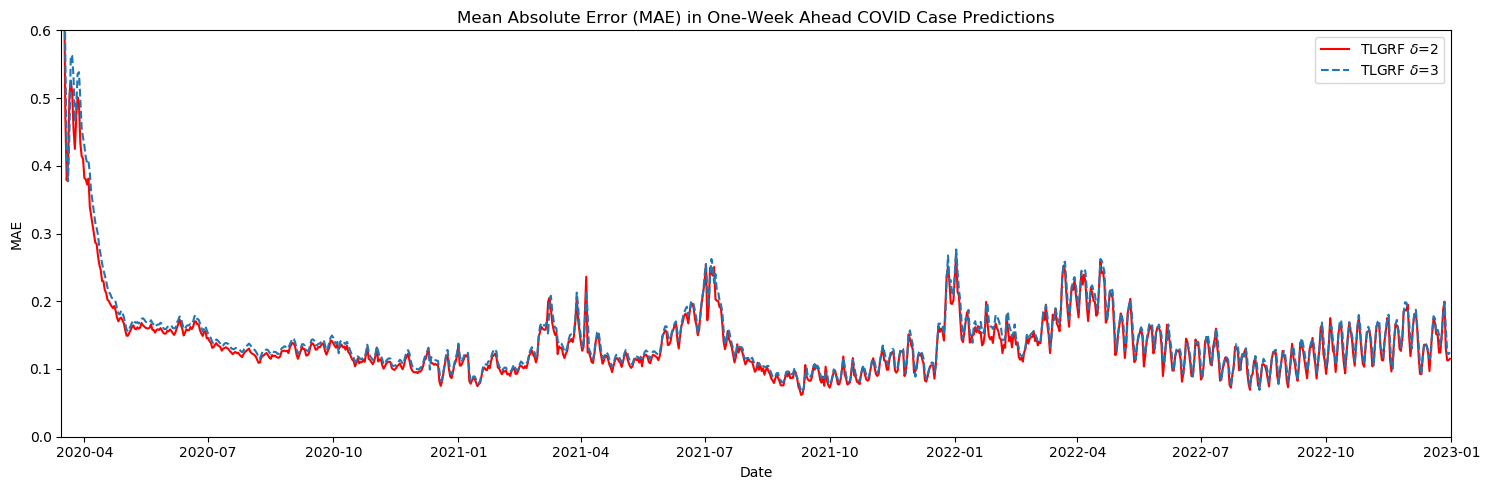

<Figure size 640x480 with 0 Axes>

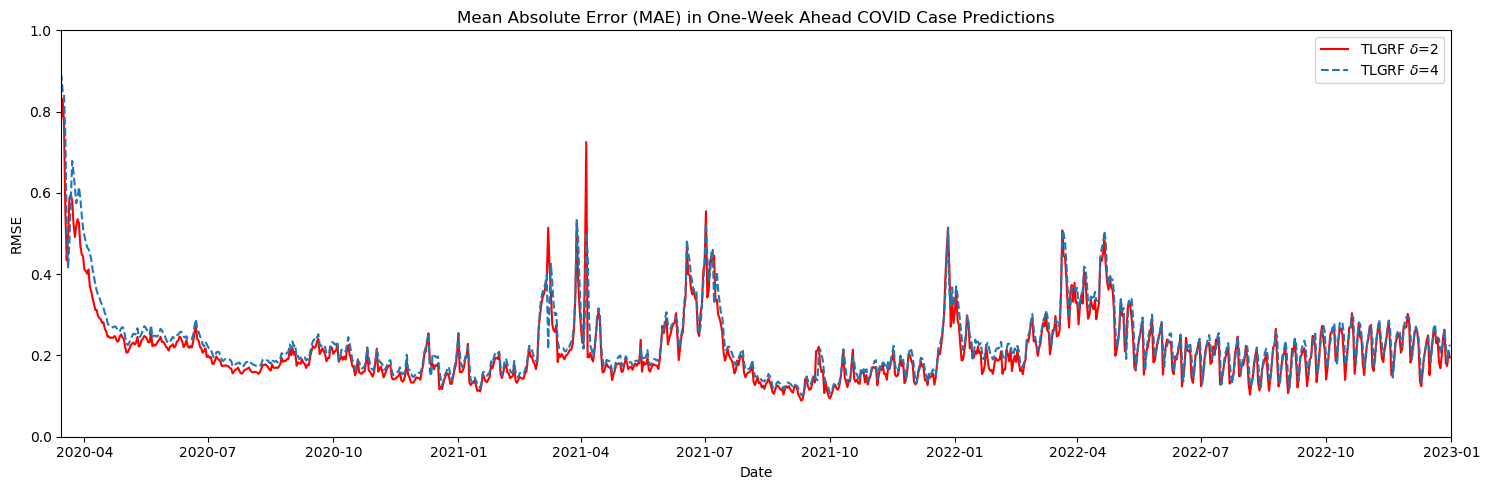

<Figure size 640x480 with 0 Axes>

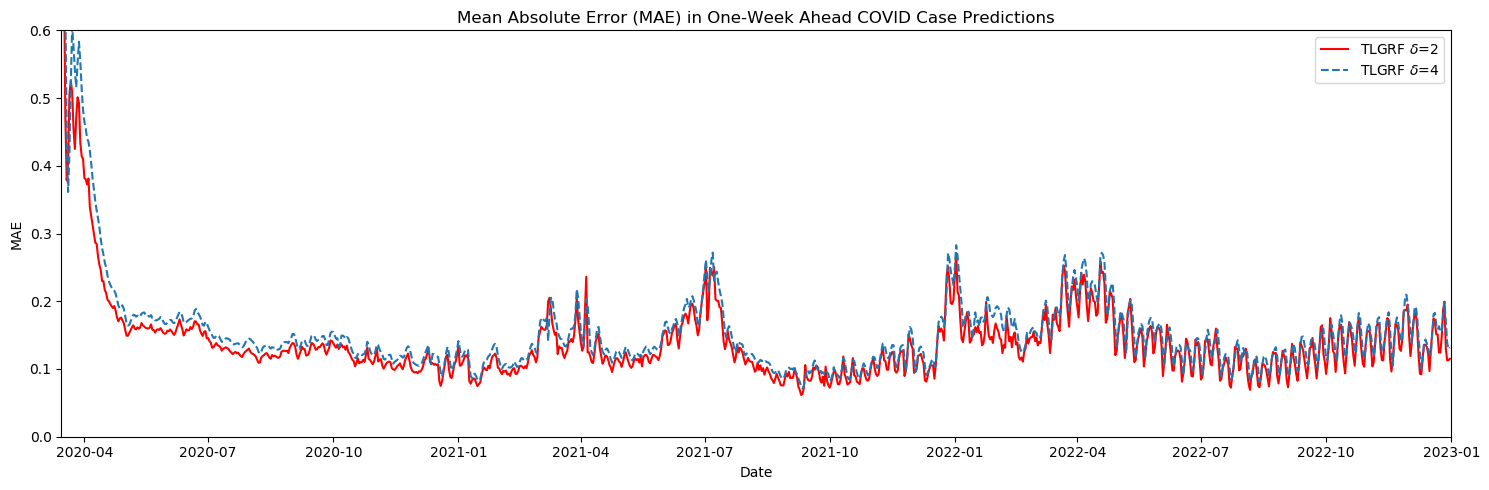

<Figure size 640x480 with 0 Axes>

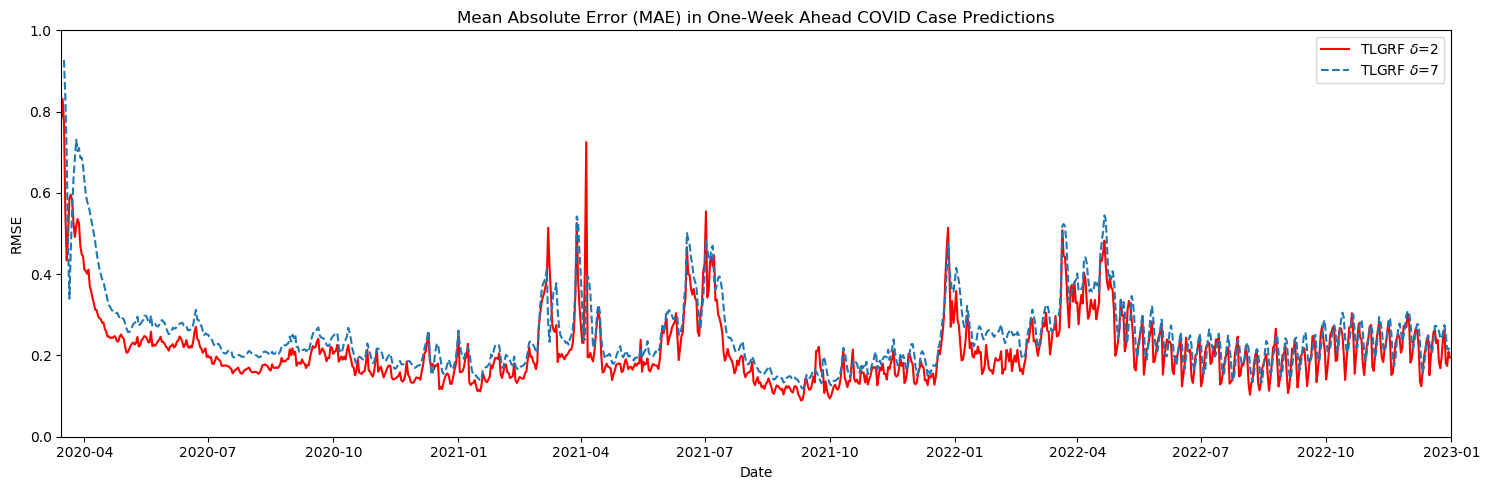

<Figure size 640x480 with 0 Axes>

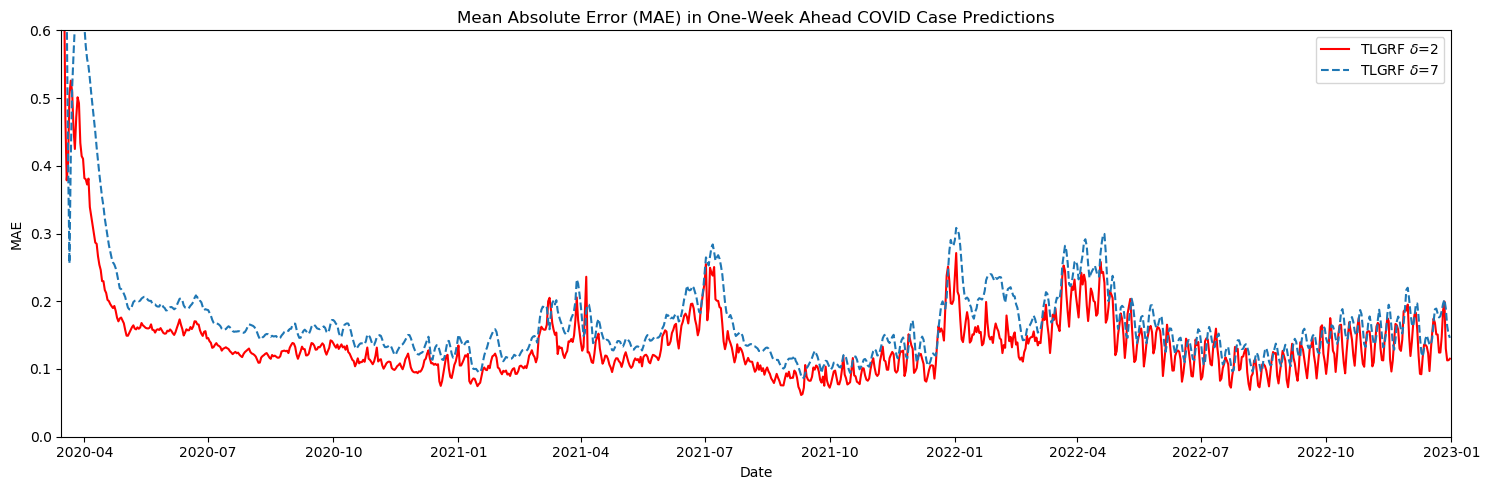

<Figure size 640x480 with 0 Axes>

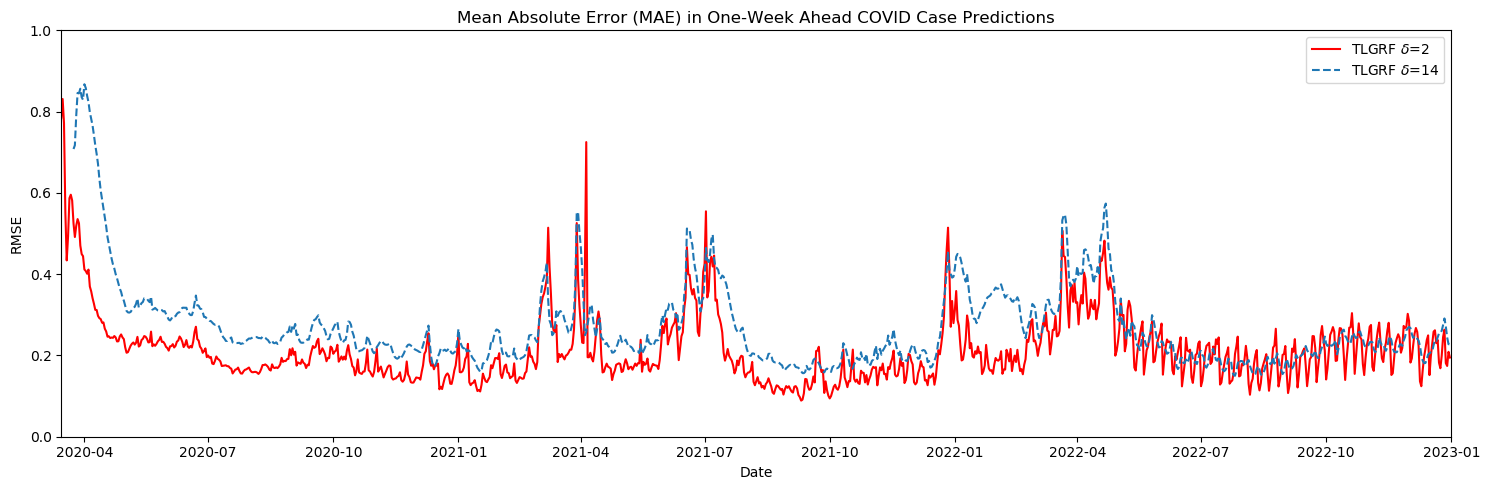

<Figure size 640x480 with 0 Axes>

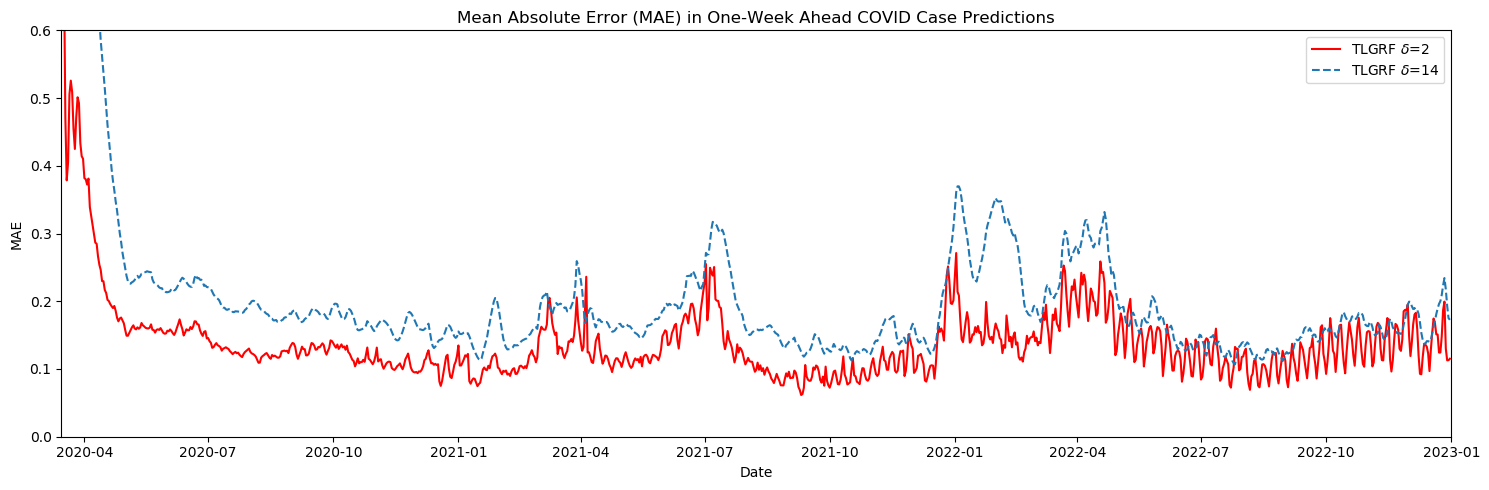

In [14]:
for delta2, metric in itertools.product([3,4,7,14],["RMSE","MAE"]):
    plot_comparison(delta1=2, delta2=delta2, metric=metric)

### Plot $\delta=2$ against others

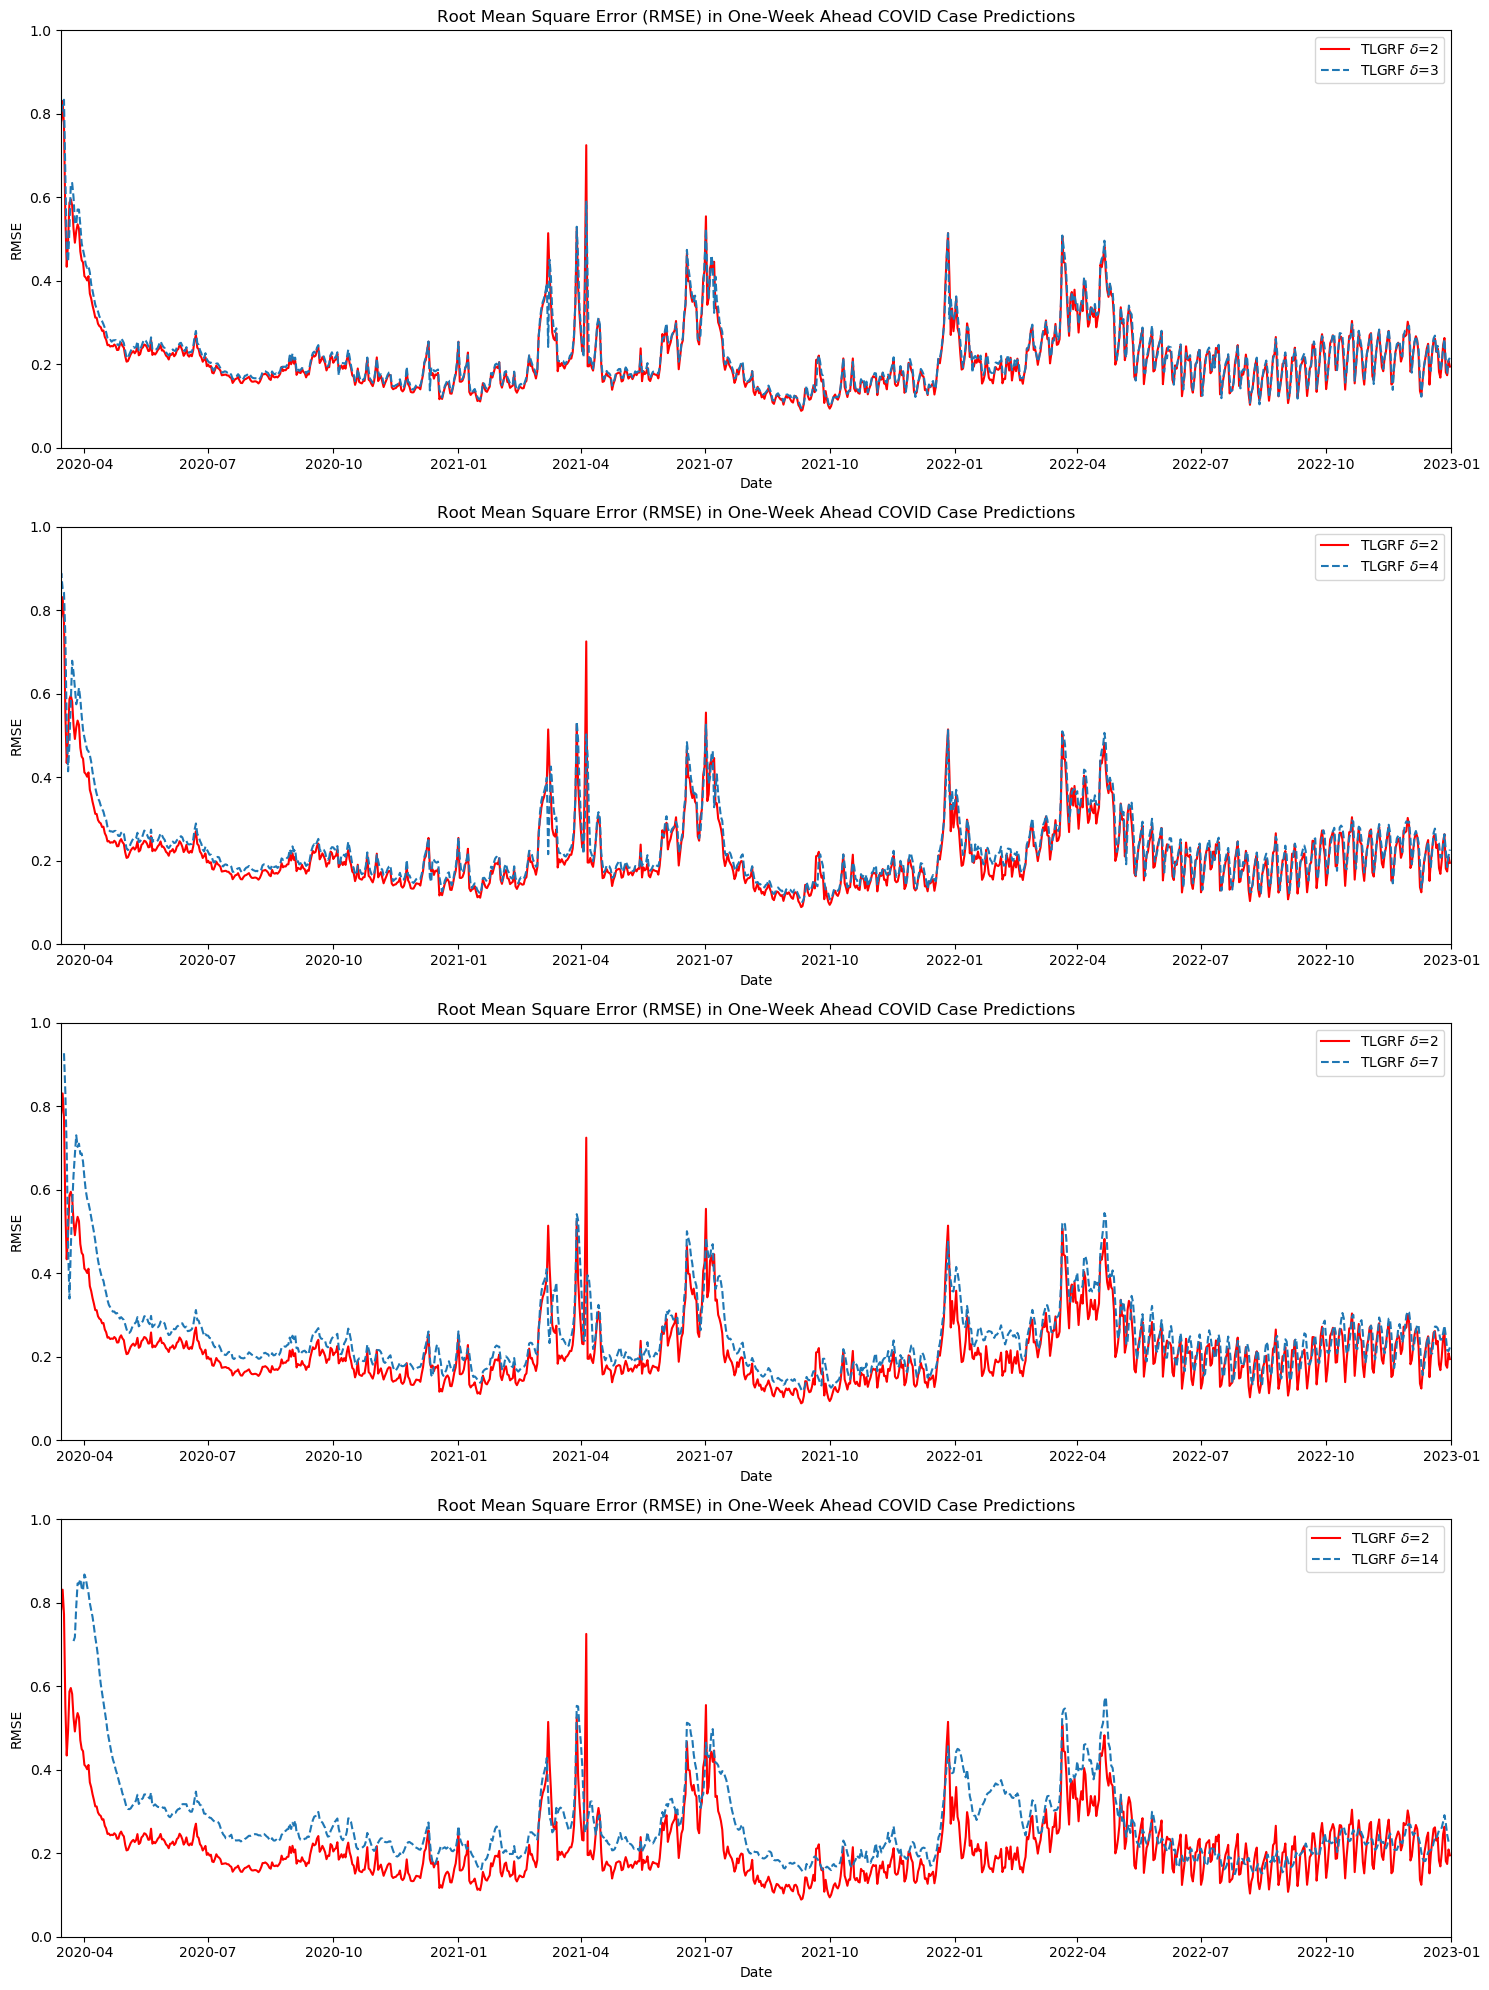

In [15]:
fig, axes = plt.subplots(len(delta_list[1:]), 1, figsize=(15,20))
for i, delta in enumerate(delta_list[1:]):
    axes[i].plot(TLGRF_delta_performance["RMSE_delta={}".format(2)], label="TLGRF $\delta$={}".format(2), color="red")
    axes[i].plot(TLGRF_delta_performance["RMSE_delta={}".format(delta)], label="TLGRF $\delta$={}".format(delta), linestyle="dashed")    
    axes[i].set(title='Root Mean Square Error (RMSE) in One-Week Ahead COVID Case Predictions', xlabel='Date', ylabel="RMSE")
    #axes[i].set_xticks(TLGRF_delta_performance.index[TLGRF_delta_performance.index.is_month_start])
    #axes[i].set_xticklabels(TLGRF_delta_performance.index[TLGRF_delta_performance.index.is_month_start].strftime('%Y-%m-%d'), rotation=45)
    #axes[i].tick_params(axis='x', which='both', bottom=False, top=False)
    axes[i].set_xlim(pd.to_datetime("2020-03-15"), pd.to_datetime("2023-01-01"))
    axes[i].set_ylim(0, 1.0)
    axes[i].legend()
    #axes[i].figure.savefig("TLGRF_Delta_RMSE_{{{}x{}}}.png".format(2,delta))
plt.tight_layout()
plt.savefig("TLGRF_Delta_RMSE.png")
plt.show()



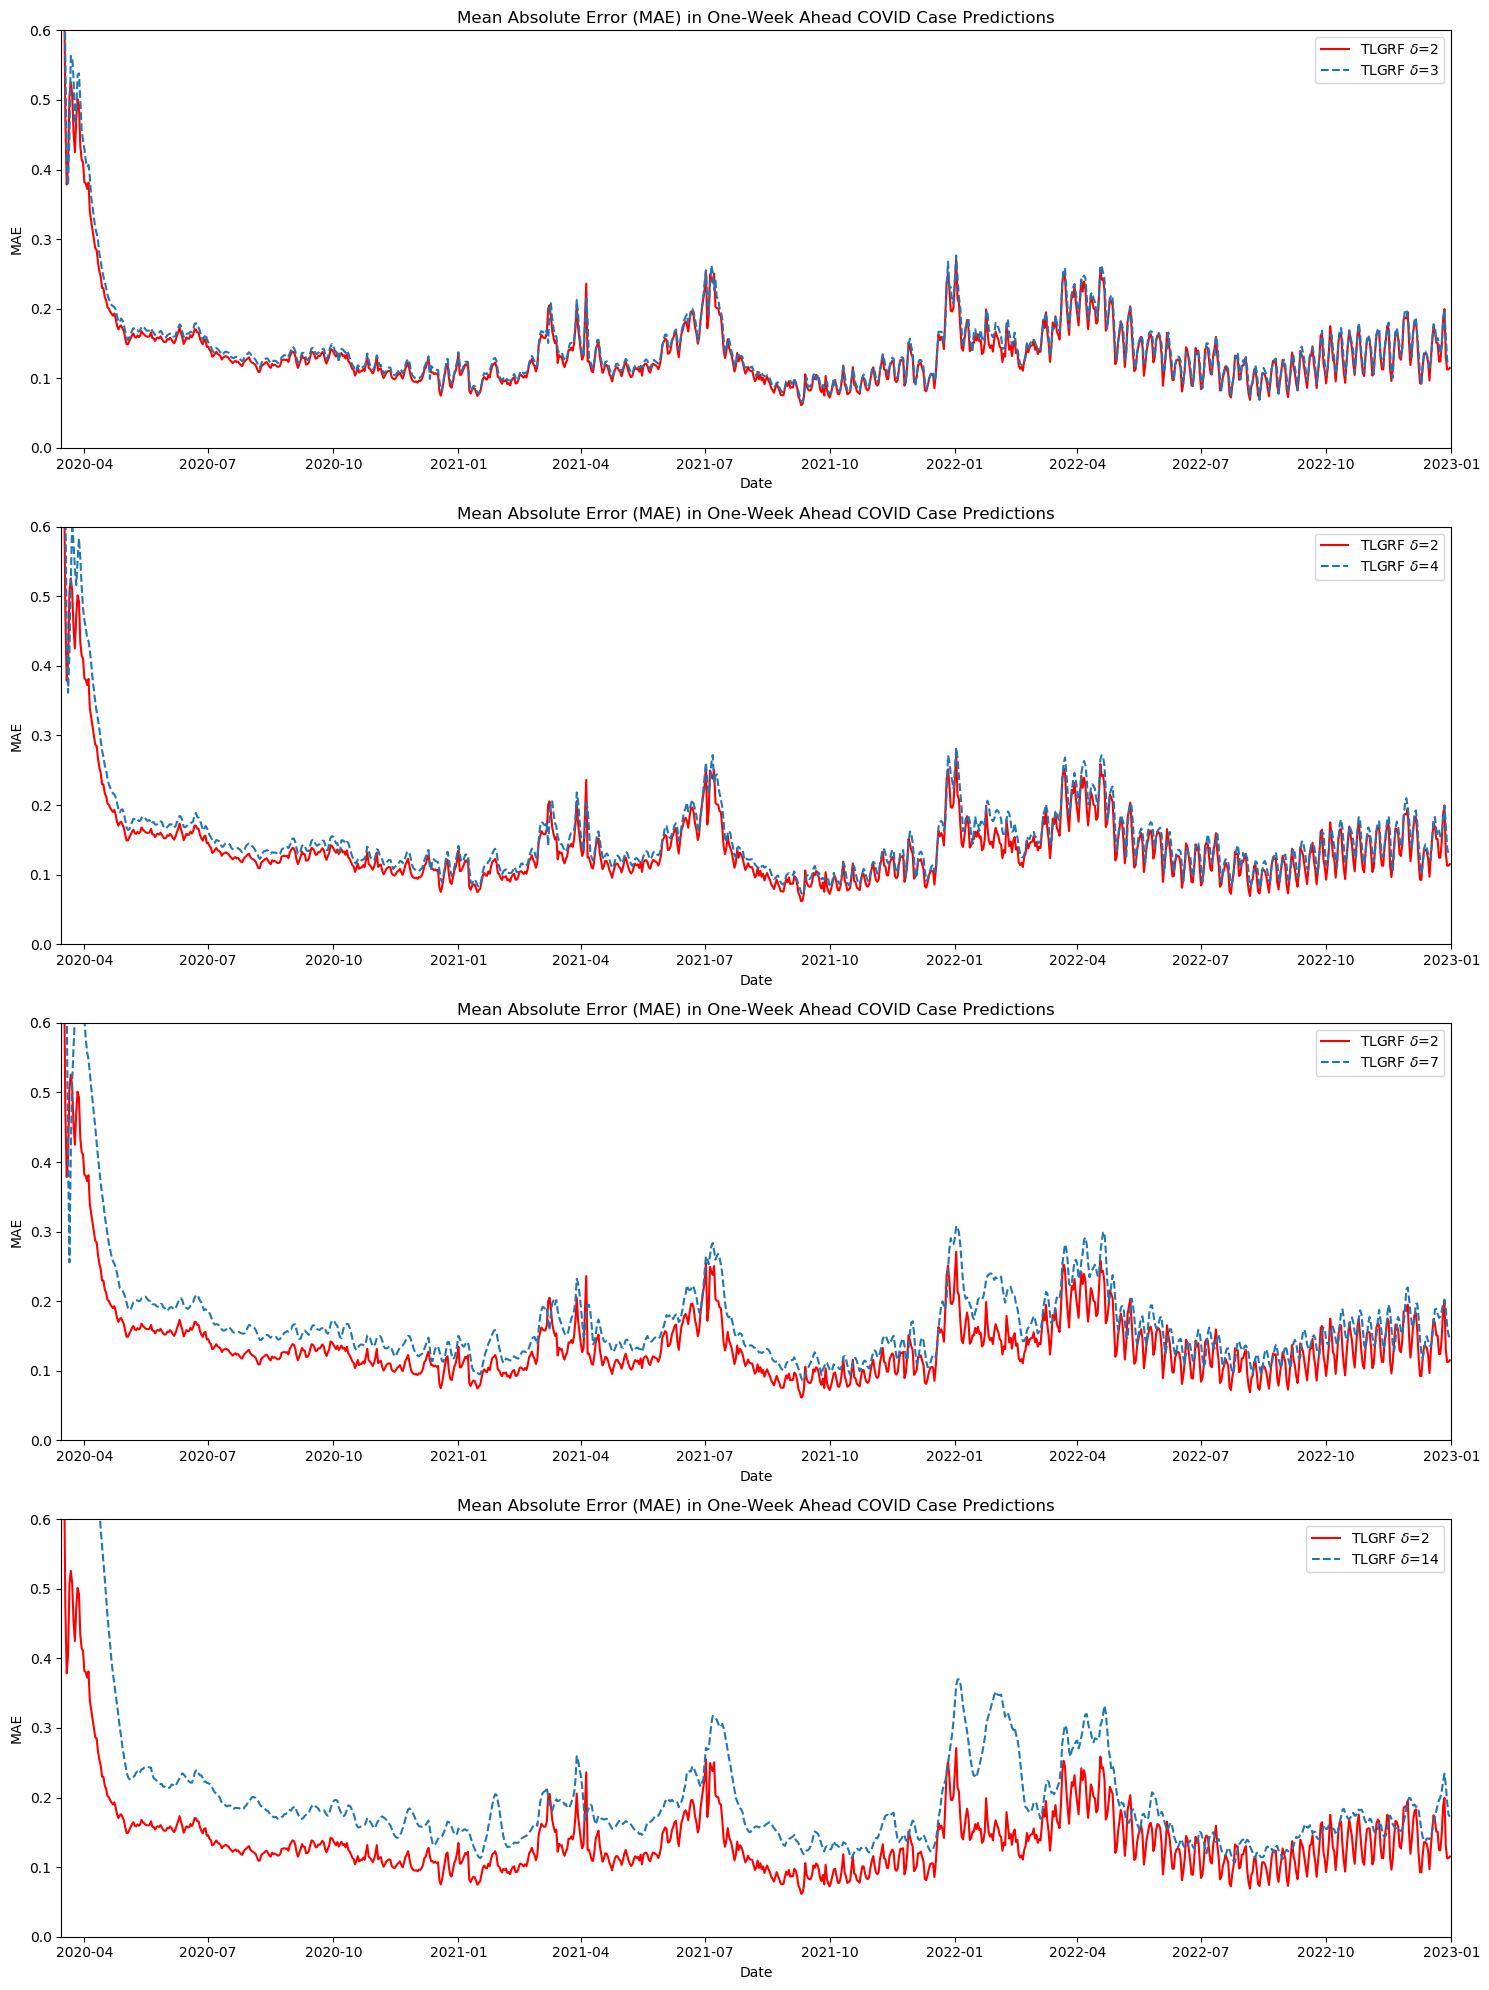

In [16]:
fig, axes = plt.subplots(len(delta_list[1:]), 1, figsize=(15,20))
for i, delta in enumerate(delta_list[1:]):
    axes[i].plot(TLGRF_delta_performance["MAE_delta={}".format(2)], label="TLGRF $\delta$={}".format(2), color="red")
    axes[i].plot(TLGRF_delta_performance["MAE_delta={}".format(delta)], label="TLGRF $\delta$={}".format(delta), linestyle="dashed")
    axes[i].set(title='Mean Absolute Error (MAE) in One-Week Ahead COVID Case Predictions', xlabel='Date', ylabel='MAE')
    axes[i].set_xlim(pd.to_datetime("2020-03-15"), pd.to_datetime("2023-01-01"))
    axes[i].set_ylim(0, 0.6)
    axes[i].legend()
plt.tight_layout()
plt.savefig("TLGRF_Delta_MAE.png")
plt.show()


### Table of Median of Daily RMSE and MAE for each Delta

In [17]:
TLGRF_delta_performance_pivot = TLGRF_delta_performance.copy()
TLGRF_delta_performance_dict = {}

TLGRF_delta_performance_dict["$\delta$"] = delta_list
TLGRF_delta_performance_dict["Median MAE"] = [TLGRF_delta_performance_pivot["MAE_delta={}".format(delta)].median() for delta in delta_list]
TLGRF_delta_performance_dict["Median RMSE"] = [TLGRF_delta_performance_pivot["RMSE_delta={}".format(delta)].median() for delta in delta_list]
TLGRF_delta_performance_dict

TLGRF_delta_performance_pivot = pd.DataFrame(TLGRF_delta_performance_dict)
TLGRF_delta_performance_pivot = TLGRF_delta_performance_pivot.sort_values(by="$\delta$", ascending=False)
TLGRF_delta_performance_pivot
#TLGRF_pivot_table = TLGRF_delta_performance.pivot_table(index=TLGRF_delta_performance.index, columns='delta', aggfunc='median')
#TLGRF_pivot_table.index = ['MAE', 'RMSE']
#TLGRF_pivot_table
print(TLGRF_delta_performance_pivot.to_string(index=False))

 $\delta$  Median MAE  Median RMSE
       14    0.172916     0.237348
        7    0.153328     0.226357
        4    0.137729     0.211669
        3    0.132329     0.202996
        2    0.126516     0.194870


In [18]:
display(TLGRF_delta_performance_pivot)

,$\delta$,Median MAE,Median RMSE
4,14,0.172916,0.237348
3,7,0.153328,0.226357
2,4,0.137729,0.211669
1,3,0.132329,0.202996
0,2,0.126516,0.194870


In [19]:
latex_table = TLGRF_delta_performance_pivot.to_latex(index=False, column_format='c|c|c', escape=False, header=['$\delta$', 'Median MAE', 'Median RMSE'], float_format='%.3f')
centered_table = '\\begin{center}\n' + latex_table + '\\end{center}'


In [20]:
print(centered_table)

\begin{center}
\begin{tabular}{c|c|c}
\toprule
$\delta$ & Median MAE & Median RMSE \\
\midrule
      14 &      0.173 &       0.237 \\
       7 &      0.153 &       0.226 \\
       4 &      0.138 &       0.212 \\
       3 &      0.132 &       0.203 \\
       2 &      0.127 &       0.195 \\
\bottomrule
\end{tabular}
\end{center}


In [21]:
TLGRF_delta_performance.to_csv("TLGRF_delta_performance.csv")